# Import

In [2]:
!pip install torchsummary

In [2]:
from torch.utils.data import DataLoader
from torchsummary import summary
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

# Loading Dataset

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root = './data', train = True, download = True, transform = transform)
testset = torchvision.datasets.CIFAR10(root = './data', train = False, download = True, transform = transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size = 32, shuffle = True)
testloader = torch.utils.data.DataLoader(testset, batch_size = 32, shuffle = False)
    

In [5]:
image, label = trainset[0]

print(f"image shape: {image.shape}")
print(f"image label: {label}")
print(f"image: {image}")
print(f"# of classes: {len(trainset.classes)}")

image shape: torch.Size([3, 32, 32])
image label: 6
image: tensor([[[-0.5373, -0.6627, -0.6078,  ...,  0.2392,  0.1922,  0.1608],
         [-0.8745, -1.0000, -0.8588,  ..., -0.0353, -0.0667, -0.0431],
         [-0.8039, -0.8745, -0.6157,  ..., -0.0745, -0.0588, -0.1451],
         ...,
         [ 0.6314,  0.5765,  0.5529,  ...,  0.2549, -0.5608, -0.5843],
         [ 0.4118,  0.3569,  0.4588,  ...,  0.4431, -0.2392, -0.3490],
         [ 0.3882,  0.3176,  0.4039,  ...,  0.6941,  0.1843, -0.0353]],

        [[-0.5137, -0.6392, -0.6235,  ...,  0.0353, -0.0196, -0.0275],
         [-0.8431, -1.0000, -0.9373,  ..., -0.3098, -0.3490, -0.3176],
         [-0.8118, -0.9451, -0.7882,  ..., -0.3412, -0.3412, -0.4275],
         ...,
         [ 0.3333,  0.2000,  0.2627,  ...,  0.0431, -0.7569, -0.7333],
         [ 0.0902, -0.0353,  0.1294,  ...,  0.1608, -0.5137, -0.5843],
         [ 0.1294,  0.0118,  0.1137,  ...,  0.4431, -0.0745, -0.2784]],

        [[-0.5059, -0.6471, -0.6627,  ..., -0.1529, -0.20

In [6]:
train_size = torch.tensor(len(trainset))
test_size = torch.tensor(len(testset))

print(f"train set size: {train_size} (shape: {train_size.shape})")
print(f"test set size: {test_size} (shape: {test_size.shape})")

# pytorch의 데이터셋은 numpy가 아니므로 
# train_size.shape, test_size.shape 가 존재하지 않는다.


train set size: 50000 (shape: torch.Size([]))
test set size: 10000 (shape: torch.Size([]))


# Input Normalization
<img src = "https://resources-public-prd.modulabs.co.kr/home-section/story-modulabs-articles-section/9ebac232-b3a3-4eeb-b526-6a112802cefe.png">

In [7]:
transform = transforms.Compose([
    transforms.ToTensor()
])
transform

Compose(
    ToTensor()
)

In [8]:
num_classes = len(trainset.classes)
print(num_classes)

10


In [9]:
class_name = trainset.classes
print(class_name)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [10]:
def imshow(img):
    img = img / 2 + 0.5 # 이미지 복원 (img - 0.5) / 0.5
    npimg = img.numpy() # matplotlib은 numpy 배열을 기대하므로
    return np.transpose(img, (1, 2, 0)) # 채널 순서 변경

In [11]:
def show_multiple_images(dataset, n_images=9):
    dataiter = iter(dataset)
    images, labels = next(dataiter)
    fig, axes = plt.subplots(3, 3, figsize=(6, 6))
    axes = axes.flatten()

    for i in range(n_images):
        ax = axes[i]
        img = imshow(images[i])
        ax.imshow(img)
        ax.set_title(f"Label: {trainset.classes[labels[i]]}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

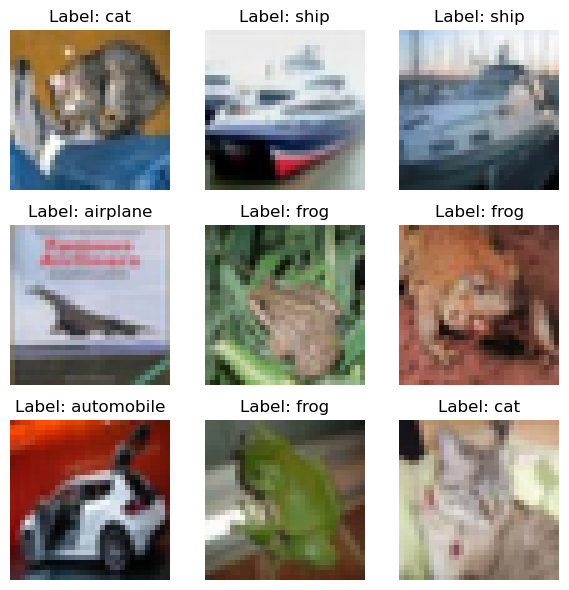

In [12]:
show_multiple_images(testloader)

# Building basic VGG Block
<img src = 'https://resources-public-prd.modulabs.co.kr/home-section/story-modulabs-articles-section/0b601bfc-cf54-4ca3-b702-3047ece08b09.png'>

In [13]:
def build_vgg_block(input_layer,
                    num_cnn = 3,
                    channel = 64,
                    block_num = 1):
    x = input_layer

    layers = []
    in_channels = x.size(1)
    for cnn_num in range(num_cnn):
        layers.append(
            nn.Conv2d(
                in_channels = in_channels,
                out_channels = channel,
                kernel_size = 3,
                stride = 1,
                padding = 1
            )
        )
        layers.append(nn.ReLU(inplace = True))
        in_channels = channel

    layers.append(
        nn.MaxPool2d(
            kernel_size = 2,
            stride = 2
        )
    )

    block = nn.Sequential(*layers)
    return block

In [14]:
class VGGNet(nn.Module):
    def __init__(self):
        super(VGGNet, self).__init__()

        self.vgg_block = build_vgg_block(torch.zeros(1, 3, 32, 32))
    def forward(self, x):
        return self.vgg_block(x)

In [15]:
model = VGGNet()
print(model)

dummy_input = torch.zeros(1, 3, 32, 32)
output = model(dummy_input)
print(output.shape)

VGGNet(
  (vgg_block): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)
torch.Size([1, 64, 16, 16])


# VGG-16

In [16]:
class VGG(nn.Module):
    def __init__(self, num_cnn_list = [2, 2, 3, 3, 3], channel_list = [64, 128, 256, 512, 512], num_classes = 10):
        super(VGG, self).__init__()
        assert len(num_cnn_list) == len(channel_list), "num_cnn_list와 channel_list의 길이가 일치해야 함."

        layers = []
        in_channels = 3

        for num_cnn, out_channels in zip(num_cnn_list, channel_list):
            layers.append(self._make_vgg_block(in_channels, out_channels, num_cnn))
            in_channels = out_channels

        self.feature_extractor = nn.Sequential(*layers)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 1 * 1, 4096),
            nn.ReLU(True),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Linear(4096, num_classes)
        )

    def _make_vgg_block(self, in_channels, out_channels, num_cnn):
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1)]
        for _ in range(num_cnn - 1):
            layers.append(nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 1))
            layers.append(nn.ReLU(True))
        layers.append(nn.MaxPool2d(kernel_size = 2, stride = 2))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x
        

In [17]:
vgg_16 = VGG()
print(vgg_16)

VGG(
  (feature_extractor): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): ReLU(inplace=True)
      (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=2, stride=2, 

# VGG-19

In [18]:
vgg_19 = VGG(
    num_cnn_list=[2, 2, 4, 4, 4],
    channel_list=[64, 128, 256, 512, 512]
)
print(vgg_19)

VGG(
  (feature_extractor): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): ReLU(inplace=True)
      (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU(inplace=True)
      (5): Conv2d(256, 256, kernel_size=(3, 3)

# VGG-13

In [19]:
def build_vgg13(num_classes=10):
    return VGG(
        num_cnn_list=[2, 2, 2, 2, 2],
        channel_list=[64, 128, 256, 512, 512],
        num_classes=num_classes
    )
vgg_13 = build_vgg13()
print(vgg_13)

VGG(
  (feature_extractor): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3

# VGG-16 vs. VGG-19

In [20]:
BATCH_SIZE = 256
EPOCH = 15

In [21]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

In [22]:
import time

current_time = time.time()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg_16 = torchvision.models.vgg16(pretrained=True)
vgg_16.to(device)

for param in vgg_16.parameters():
    param.requires_grad = True
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg_16.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

vgg_16_train_losses = []
vgg_16_val_accuracy = []

for epoch in range(EPOCH):
    vgg_16.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (inputs, labels) in enumerate(trainloader, 0):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = vgg_16(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % 100 == 99:
            print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / i + 1:.3f}")
            
    train_loss = running_loss / len(trainloader)
    train_acc = 100 * correct / total
    vgg_16_train_losses.append(train_loss)

    print(f"Epoch {epoch + 1}: Train Accuracy: {train_acc:.2f}%")

    vgg_16.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = vgg_16(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total
    vgg_16_val_accuracy.append(val_acc)

    print(f"Epoch {epoch + 1}: Validation Accuracy: {val_acc:.2f}%")

print("Finished Training")
print(time.time() - current_time)

/opt/conda/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[1,   100] loss: 3.999
Epoch 1: Train Accuracy: 39.06%
Epoch 1: Validation Accuracy: 65.84%
[2,   100] loss: 1.899
Epoch 2: Train Accuracy: 71.71%
Epoch 2: Validation Accuracy: 76.37%
[3,   100] loss: 1.656
Epoch 3: Train Accuracy: 78.73%
Epoch 3: Validation Accuracy: 78.64%
[4,   100] loss: 1.539
Epoch 4: Train Accuracy: 82.31%
Epoch 4: Validation Accuracy: 81.04%
[5,   100] loss: 1.460
Epoch 5: Train Accuracy: 84.79%
Epoch 5: Validation Accuracy: 81.90%
[6,   100] loss: 1.402
Epoch 6: Train Accuracy: 86.78%
Epoch 6: Validation Accuracy: 83.50%
[7,   100] loss: 1.349
Epoch 7: Train Accuracy: 88.51%
Epoch 7: Validation Accuracy: 84.02%
[8,   100] loss: 1.296
Epoch 8: Train Accuracy: 90.00%
Epoch 8: Validation Accuracy: 84.30%
[9,   100] loss: 1.251
Epoch 9: Train Accuracy: 91.24%
Epoch 9: Validation Accuracy: 84.86%
[10,   100] loss: 1.220
Epoch 10: Train Accuracy: 92.56%
Epoch 10: Validation Accuracy: 84.70%
[11,   100] loss: 1.196
Epoch 11: Train Accuracy: 93.58%
Epoch 11: Validation

In [33]:
torch.save(vgg_16.state_dict(), "vgg16_final.pth")

In [23]:
current_time = time.time()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg_19 = torchvision.models.vgg19(pretrained=True)
vgg_19.to(device)

for param in vgg_19.parameters():
    param.requires_grad = True
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg_19.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

vgg_19_train_losses = []
vgg_19_val_accuracy = []

for epoch in range(EPOCH):
    vgg_19.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (inputs, labels) in enumerate(trainloader, 0):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = vgg_19(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % 100 == 99:
            print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / i + 1:.3f}")

    train_loss = running_loss / len(trainloader)
    vgg_19_train_losses.append(train_loss)

    train_acc = 100 * correct / total
    print(f"Epoch {epoch + 1}: Train Accuracy: {train_acc:.2f}%")

    vgg_19.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = vgg_19(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total
    vgg_19_val_accuracy.append(val_acc)

    print(f"Epoch {epoch + 1}: Validation Accuracy: {val_acc:.2f}%")

print("Finished Training")
print(time.time() - current_time)

/opt/conda/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[1,   100] loss: 3.766
Epoch 1: Train Accuracy: 42.90%
Epoch 1: Validation Accuracy: 67.96%
[2,   100] loss: 1.815
Epoch 2: Train Accuracy: 74.19%
Epoch 2: Validation Accuracy: 78.72%
[3,   100] loss: 1.583
Epoch 3: Train Accuracy: 81.08%
Epoch 3: Validation Accuracy: 82.12%
[4,   100] loss: 1.481
Epoch 4: Train Accuracy: 84.34%
Epoch 4: Validation Accuracy: 82.73%
[5,   100] loss: 1.408
Epoch 5: Train Accuracy: 86.53%
Epoch 5: Validation Accuracy: 84.01%
[6,   100] loss: 1.348
Epoch 6: Train Accuracy: 88.39%
Epoch 6: Validation Accuracy: 84.51%
[7,   100] loss: 1.299
Epoch 7: Train Accuracy: 89.96%
Epoch 7: Validation Accuracy: 85.27%
[8,   100] loss: 1.261
Epoch 8: Train Accuracy: 91.27%
Epoch 8: Validation Accuracy: 85.90%
[9,   100] loss: 1.217
Epoch 9: Train Accuracy: 92.54%
Epoch 9: Validation Accuracy: 85.82%
[10,   100] loss: 1.192
Epoch 10: Train Accuracy: 93.45%
Epoch 10: Validation Accuracy: 85.76%
[11,   100] loss: 1.158
Epoch 11: Train Accuracy: 94.60%
Epoch 11: Validation

In [34]:
torch.save(vgg_19.state_dict(), "vgg19_final.pth")

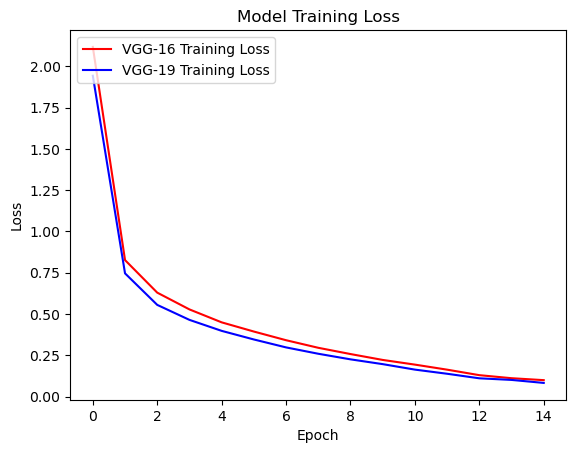

In [24]:
plt.plot(vgg_16_train_losses, 'r', label="VGG-16 Training Loss")
plt.plot(vgg_19_train_losses, 'b', label="VGG-19 Training Loss")

plt.title('Model Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

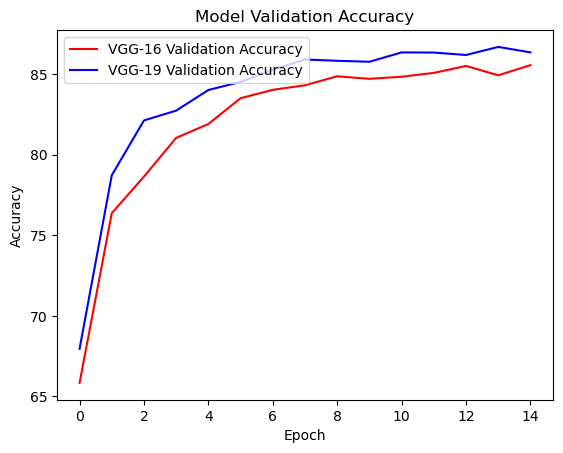

In [25]:
plt.plot(vgg_16_val_accuracy, 'r', label="VGG-16 Validation Accuracy")
plt.plot(vgg_19_val_accuracy, 'b', label="VGG-19 Validation Accuracy")

plt.title('Model Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# CIFAR-10

In [26]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터 전처리
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.4914, 0.4822, 0.4465),
        std=(0.2470, 0.2435, 0.2616)
    )
])

# CIFAR-10 train dataset
train_dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transform_train
)

# DataLoader
train_loader = DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)


# Plain BLock vs. Residual Block

In [27]:
class PlainBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, 3, stride, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        return F.relu(out)


In [28]:
class ResidualBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, 3, stride, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, 1, stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return F.relu(out)


# ResNet

In [29]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super().__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, 3, 1, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        self.layer1 = self._make_layer(block, 64,  num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for s in strides:
            layers.append(block(self.in_planes, planes, s))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)


# ResNet-34 vs. ResNet-50

In [53]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [54]:
plain34 = ResNet(PlainBlock,    [3, 4, 6, 3]).to(device)
res34   = ResNet(ResidualBlock, [3, 4, 6, 3]).to(device)

plain50 = ResNet(PlainBlock,    [3, 4, 6, 3]).to(device)
res50   = ResNet(ResidualBlock, [3, 4, 6, 3]).to(device)

models = {
    "Plain-34": plain34,
    "Res-34": res34,
    "Plain-50": plain50,
    "Res-50": res50
}

In [55]:
def train_and_validate(model, train_loader, val_loader, optimizer, criterion, epochs):
    history = {
        "train_loss": [],
        "val_loss": [],
        "val_acc": []
    }

    for epoch in range(epochs):
        # ---------- Train ----------
        model.train()
        train_loss = 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        history["train_loss"].append(train_loss)

        # ---------- Validation ----------
        model.eval()
        val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                output = model(x)
                loss = criterion(output, y)

                val_loss += loss.item()
                _, pred = output.max(1)
                correct += (pred == y).sum().item()
                total += y.size(0)

        val_loss /= len(val_loader)
        val_acc = 100 * correct / total

        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"[Epoch {epoch+1}/{epochs}] "
              f"Train Loss: {train_loss:.4f} | "
              f"Val Loss: {val_loss:.4f} | "
              f"Val Acc: {val_acc:.2f}%")

    return history

In [58]:
from torch.utils.data import random_split, DataLoader

dataset = train_loader.dataset

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=128, shuffle=False)

In [59]:
EPOCHS = 15
criterion = nn.CrossEntropyLoss()
history = {}

for name, model in models.items():
    print(f"\n🚀 Training {name}")
    optimizer = torch.optim.SGD(
        model.parameters(),
        lr=0.1,
        momentum=0.9,
        weight_decay=1e-4
    )

    history[name] = train_and_validate(
        model,
        train_loader,
        val_loader,
        optimizer,
        criterion,
        EPOCHS
    )


🚀 Training Plain-34
[Epoch 1/15] Train Loss: 2.2327 | Val Loss: 2.0239 | Val Acc: 18.07%
[Epoch 2/15] Train Loss: 1.9298 | Val Loss: 1.9276 | Val Acc: 23.18%
[Epoch 3/15] Train Loss: 1.8675 | Val Loss: 1.9704 | Val Acc: 22.31%
[Epoch 4/15] Train Loss: 1.8301 | Val Loss: 1.8254 | Val Acc: 28.20%
[Epoch 5/15] Train Loss: 1.8051 | Val Loss: 1.8486 | Val Acc: 28.40%
[Epoch 6/15] Train Loss: 1.7843 | Val Loss: 1.8680 | Val Acc: 26.44%
[Epoch 7/15] Train Loss: 1.7092 | Val Loss: 1.7930 | Val Acc: 30.74%
[Epoch 8/15] Train Loss: 1.6108 | Val Loss: 1.6624 | Val Acc: 35.35%
[Epoch 9/15] Train Loss: 1.5211 | Val Loss: 1.4475 | Val Acc: 44.76%
[Epoch 10/15] Train Loss: 1.4236 | Val Loss: 1.3858 | Val Acc: 48.30%
[Epoch 11/15] Train Loss: 1.3261 | Val Loss: 1.3669 | Val Acc: 49.51%
[Epoch 12/15] Train Loss: 1.2519 | Val Loss: 1.2815 | Val Acc: 54.49%
[Epoch 13/15] Train Loss: 1.1642 | Val Loss: 1.3397 | Val Acc: 50.78%
[Epoch 14/15] Train Loss: 1.0860 | Val Loss: 1.2648 | Val Acc: 56.91%
[Epoch 1

In [60]:
os.makedirs("checkpoints", exist_ok=True)

for name, model in models.items():
    path = f"checkpoints/{name}.pth"
    torch.save(model.state_dict(), path)
    print(f"Saved: {path}")

Saved: checkpoints/Plain-34.pth
Saved: checkpoints/Res-34.pth
Saved: checkpoints/Plain-50.pth
Saved: checkpoints/Res-50.pth


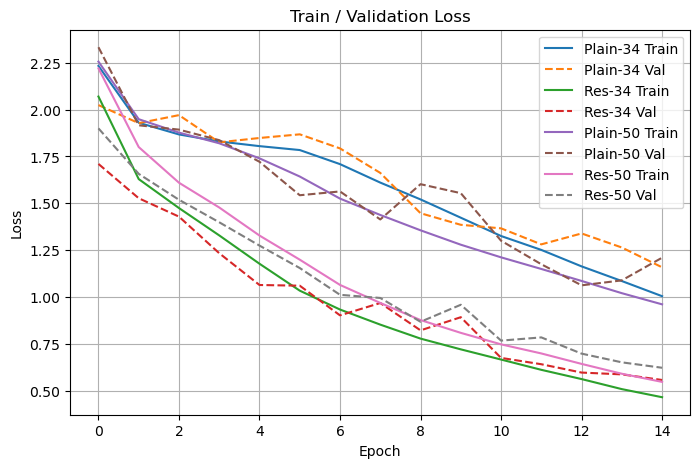

In [61]:
plt.figure(figsize=(8, 5))
for name, h in history.items():
    plt.plot(h["train_loss"], label=f"{name} Train")
    plt.plot(h["val_loss"], linestyle="--", label=f"{name} Val")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train / Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

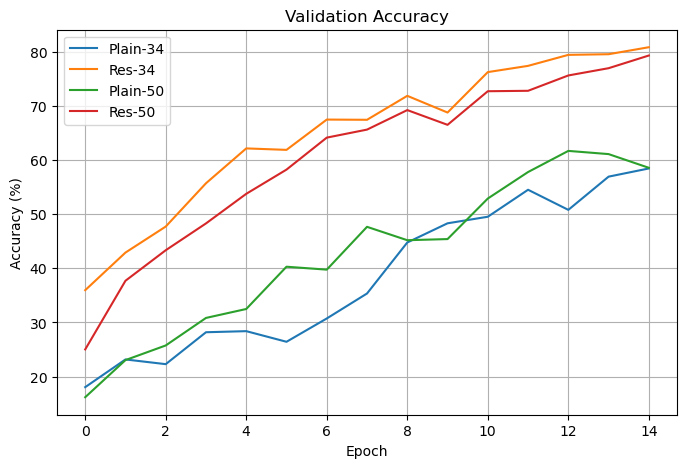

In [62]:
plt.figure(figsize=(8, 5))
for name, h in history.items():
    plt.plot(h["val_acc"], label=name)

plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()